## Условие задачи

Решим задачу для квазилинейного уравнения переноса:

$\left\{\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}  = 0,\  0 < x \leq 1\\
u(x,0)= \frac{4}{\pi} arctg(x-2) + 2\\
u(0,t) = (2-\frac{4}{\pi} arctg(2)) e^{-t} \\ 
\end{aligned}\\
\right. $

Граничные условия были предожены кафедральным преподавателем, как финитные по $x$ и $t$, а также, чтобы обеспечить затухающий профиль в нуле координат.

###### Исследование характеристик
В точках пересечения проекций его характеристик, решение будет разрывным. Посмотрим как будут вести себя проекции характеристик в заданных областях. Уравнение характеристик будет иметь вид:

$\frac{dt}{1}=\frac{dx}{u}$

Отсюда

$\left\{\begin{aligned}
u = u(x_{0},t_{0})= const \\
t-t_{0} = \frac{1}{u} (x-x_{0}) \\ 
\end{aligned}\\
\right. $

Воспользуемся начальным и граничным условиями для получения двух семейств кривых:
    
1) $t_0=0: t=\frac{1}{\frac{4}{\pi} arctg(x_0-2) + 2}(x-x_0)$

2) $x_0=0: t=\frac{1}{(2 - \frac{4}{\pi} arctg(2)) e^{-t_0}} x +t_0$


Проведём предварительный анализ для сходимости системы.

In [1]:
import math 
from math import *
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

Определим функции характеристик через массивы, где итерирование будет идти по соответствующему неизвестному параметру: $x_0$ или $t_0$ .

In [2]:
def ch1(x):
    return [((1/((4/math.pi)*math.atan(x0-2)+2))*(x-x0)) for x0 in np.arange(0, 1.1, .1)]

def ch2(x):
    return [(1/((2-(4/math.pi)*math.atan(2))*exp(-t0)) * (x) + t0) for t0 in np.arange(0, 1.1, .1)]

Построим соответствующие графики.

In [3]:
x_list = np.arange(0, 1.1, .1)

ch1_list = [ch1(x) for x in x_list]
ch2_list = [ch2(x) for x in x_list]

#ch2_list

<IPython.core.display.Javascript object>


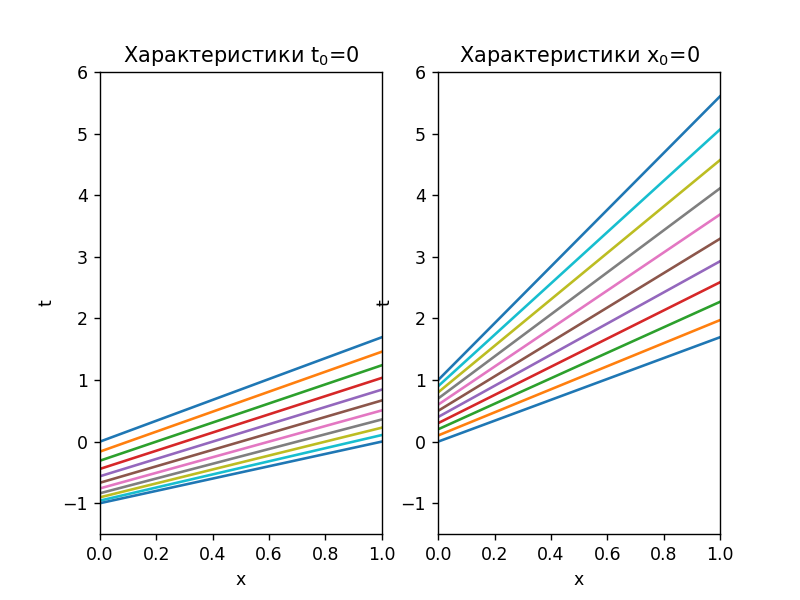

In [4]:
%matplotlib notebook

plt.subplot(1, 2, 1)
plt.ylim(-1.5,6)
#plt.ylim(0,2)
plt.xlim(0,1)
plt.plot(x_list, ch1_list) 
plt.title('Характеристики t$_{0}$=0',loc='center')
plt.ylabel('t')
plt.xlabel('x')
plt.subplot(1, 2, 2)
plt.ylim(-1.5,6)
plt.xlim(0,1)
plt.plot(x_list, ch2_list) 
plt.title('Характеристики x$_{0}$=0',loc='center')
plt.ylabel('t')
plt.xlabel('x')


plt.show()

Как видим, в заданных областях пересечений нет. Следовательно, нет так называемого опрокидывания волны, и во всей области решение будет представимо через разностную схему.

# Численное решение

## Сетка
Область задачи: $0 < x \leq 1,~~0<t<T $. Cетку с шагом $h$ по $x$ и шагом $\tau$ по $t$:

$h =\frac{1}{N},$
$\tau=\frac{1}{M}.$

Будем рассматривать сеточную функцию $y^m_{n}=u(x_n,t_m)$

## Шаблон

Перепишем исходное уравнение, приведя его к дивергентному виду: 

$$\frac{\partial u}{\partial t} + \frac{\partial (u^2/2)}{\partial x} = 0 $$

Для рассматриваемой задачи будем использовать четырехточечный шаблон "Квадрат". Он безусловно устойчив и аппроксимирует задачу как $ O({h}^2, {\tau}^2)$.

Таким образом, разностная схема задачи имеет вид:

$$\frac{y^{m+1}_n - y^m_{n} + y^{m+1}_{n+1} - y^m_{n+1}}{2\tau} + \frac{(y^{m+1}_{n})^{2} - (y^{m}_{n})^{2} + (y^{m+1}_{n+1})^2 - (y^{m}_{n+1})^2}{4h}=0$$

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= \frac{4}{\pi} arctg(n h-2) + 2 \\
y^{m}_0 = (2-\frac{4}{\pi} arctg(2))  e^{-m\tau } 
\end{aligned}\\
\right. $$


Обратим внимание, что схема порождает нелинейное уравнение на $ y^{m+1}_{n+1}.$ Будем решать его методом Ньютона.

$$ {y^{m+1}_{n+1}}^{(s+1)} = {y^{m+1}_{n+1}}^{(s)} - \frac{ f({y^{m+1}_{n+1}}^{(s)}) }  { f'({y^{m+1}_{n+1}}^{(s)}) } $$

До достижения заданной точности $ \epsilon $: $$ | {y^{m+1}_{n+1}}^{(s+1)} - {y^{m+1}_{n+1}}^{(s)} | \leq \epsilon $$

## Собственно, решение

In [5]:
epsilon = 0.0001
N = 50;
M = 50

In [6]:
h_x=(1)/(N)
h_t=(1)/(M)

In [7]:
y=np.zeros((M,N))

Начальные и конечные значения

In [8]:
for n in np.arange(N):
        y[0][n] = ((4. /math.pi) * math.atan(h_x * n - 2) + 2)

for m in np.arange(M):
        y[m][0] = (2 - (4./ math.pi) * math.atan(2)) * exp(-h_t * m)

Высчитывание схемы

In [9]:
def F(m,n): 
    return (((y[m][n]) ** 2 ) / 2.)


def f(mp1, np1): 
    n = np1-1
    m = mp1-1
    return ( float(y[mp1][n]-y[m][n] + y[mp1][np1]-y[m][np1]) / (2.*h_t) + float(F(mp1, np1)-F(mp1,n) + F(m, np1)-F(m,n)) / (2.*h_x) )

def df(mp1,np1):
    return (1/(2.*h_t) + y[mp1][np1]/(2. * h_x))

Метод Ньютона

In [10]:
for m in np.arange(M)[0:M-1]:
    for n in np.arange(N)[0:N-1]:
        eps = epsilon + 1; # > epsilon
        while eps > epsilon:
            ep = f(m+1, n+1) / float(df( m+1, n+1))
            y[m+1][n+1] = y[m+1][n+1] - ep
            eps = abs(ep)  

# Построим график решения.

<IPython.core.display.Javascript object>


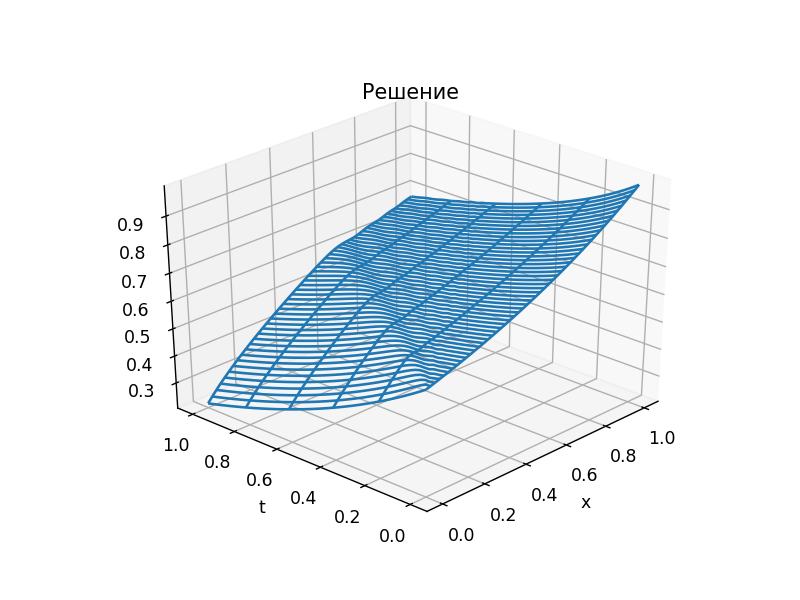

In [11]:
%matplotlib notebook

tm = np.linspace(0,1, num=M)
xn = np.linspace(0, 1, num=N)

X, T = np.meshgrid(xn, tm)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(X, T, y, rstride=10,cstride=1)
plt.title('Решение')
plt.xlabel('x')
plt.ylabel('t')
plt.show()